In [1]:
import pandas as pd
import numpy as np
from prepross import cleaned_fr
import seaborn as sns
import matplotlib.pyplot as plt

ML Lib:

In [2]:
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Experiment 1

Fitting some basic models and assessing their performance without any parameter fine-tunning.

In [3]:
# Models in experiment 1
models = {
    'BernoulliNB' : BernoulliNB(),
    'GaussianNB' : GaussianNB(),
    'DTr' : DecisionTreeClassifier(),
    'ExTrs': ExtraTreesClassifier(),
    'KNeigh' : KNeighborsClassifier(),
    'NearCentr' : NearestCentroid(),
    'svc': SVC(),
    'logistic' : LogisticRegression(),
    'MLP' : MLPClassifier()
}

In [4]:
# Importing cleaned frame
df = cleaned_fr()

# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Times to repeat Kfold instance
rKF = RepeatedKFold(n_repeats=34, n_splits=3, random_state=23)

In [5]:
_folds, _names, _accuracy, _precision, _recall, _f1, _auc, _set_type = [], [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    #print("*"*88)
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):

        #_folds.append(fold_id)
        #_names.append(MODEL_NAME)
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('scaler', MinMaxScaler()),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)

            try:
                # Some models do not have auc value
                y_proba = _local_pipe.predict_proba(X1)[:, 1]  # Probabilities for the positive class
                _auc.append( roc_auc_score(Y1, y_proba) )
            except:
                _auc.append( np.NaN )
                #print(f"{MODEL_NAME} with PROBA exception")
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

d:\Matematica\Data Science\_PersonalProjects\prjenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Matematica\Data Science\_PersonalProjects\prjenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Matematica\Data Science\_PersonalProjects\prjenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Matematica\Data Science\_PersonalProjects\prjenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

In [6]:
# Saving in DataFrame
result_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1, 'auc':_auc} )

In [7]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test'])

set,train,test
model_name,,
BernoulliNB,0.893622,0.890267
DTr,0.920281,0.881616
ExTrs,0.920281,0.884246
GaussianNB,0.920259,0.917693
KNeigh,0.917249,0.902545
MLP,0.920459,0.916713
NearCentr,0.896776,0.896772
logistic,0.898568,0.897380
svc,0.922178,0.916177


In [13]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test'])*100

set,train,test
model_name,,
BernoulliNB,1.878098,3.715739
DTr,1.723504,5.393111
ExTrs,1.723504,5.160378
GaussianNB,1.536121,3.880218
KNeigh,1.926455,3.928617
MLP,1.718937,3.707150
NearCentr,1.784173,3.562909
logistic,1.742198,3.644113
svc,1.724346,3.639790


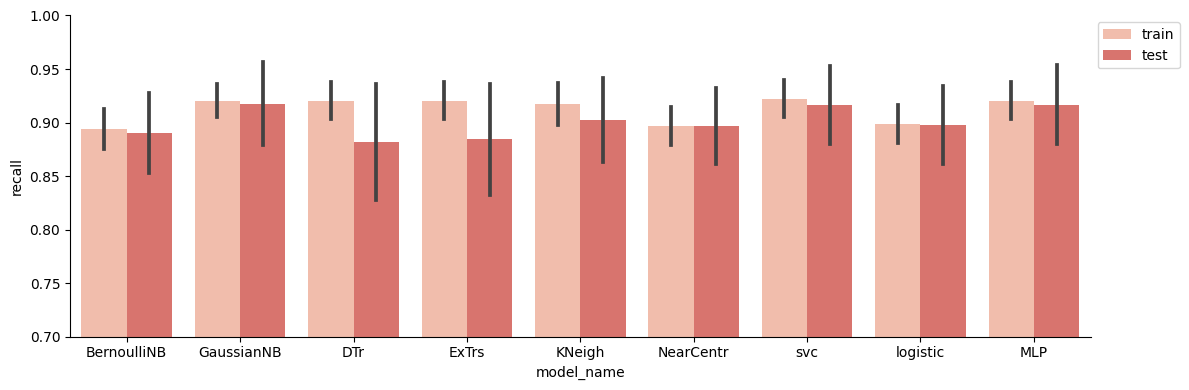

In [8]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result_df.filter(['fold_id', 'model_name', 'set'] + ["recall"]),
    x="model_name", y="recall", hue="set",
    palette="Reds", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.7, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('experiment1_recall.png', dpi=200 )
plt.show()

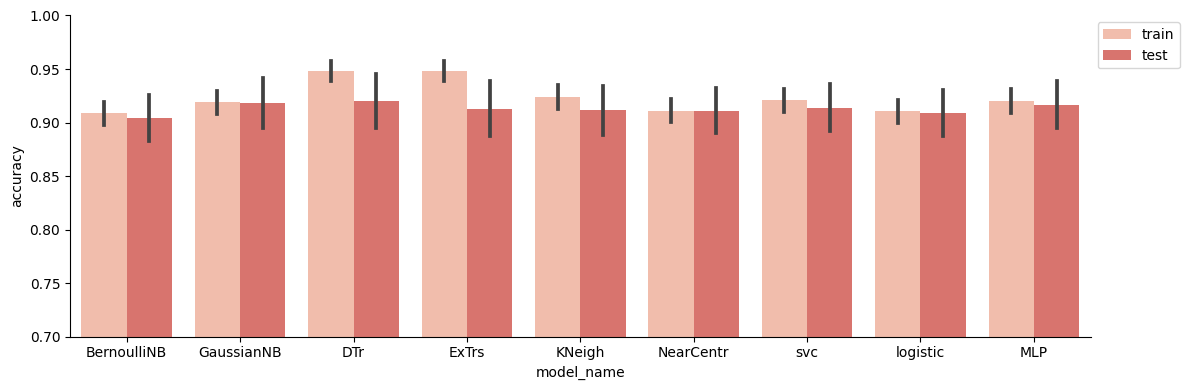

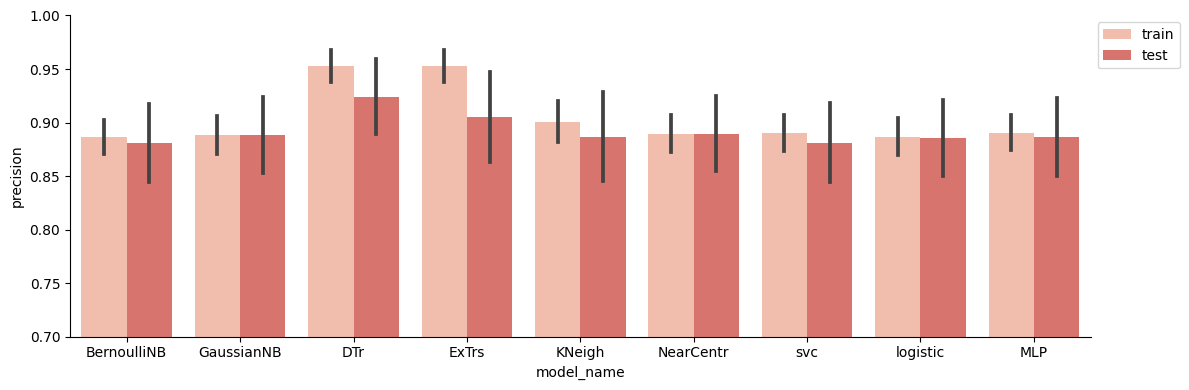

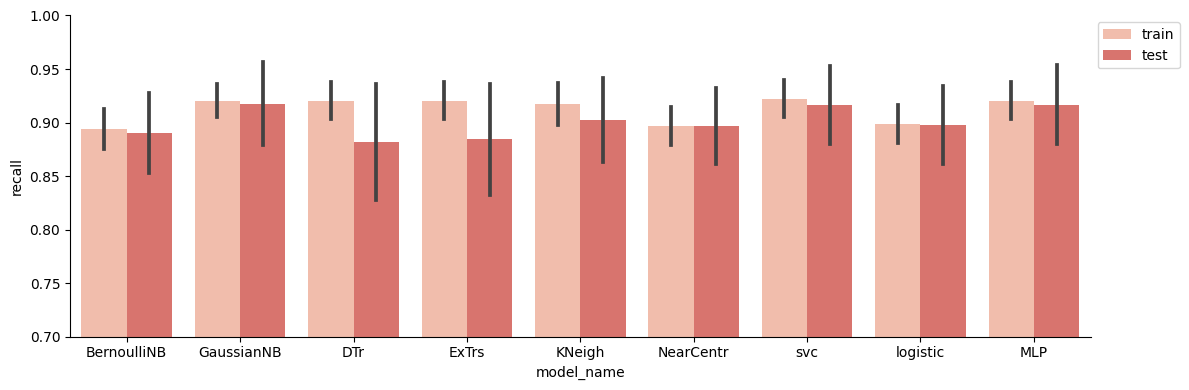

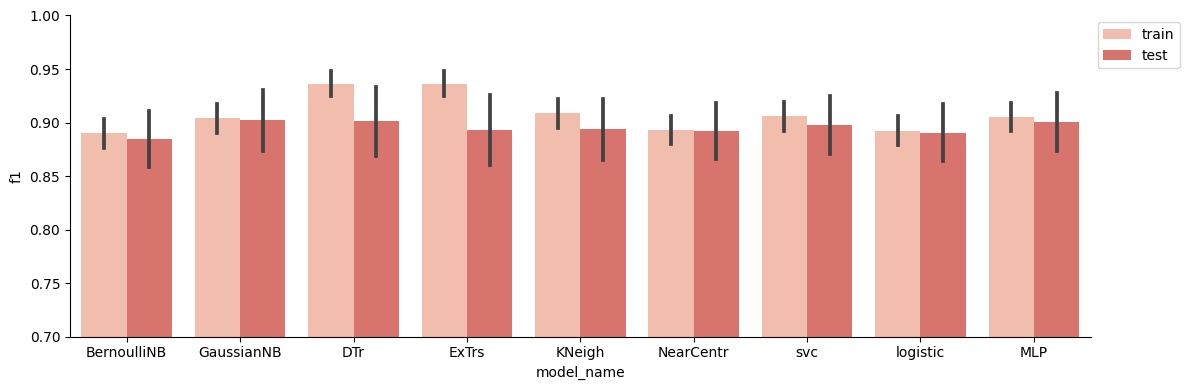

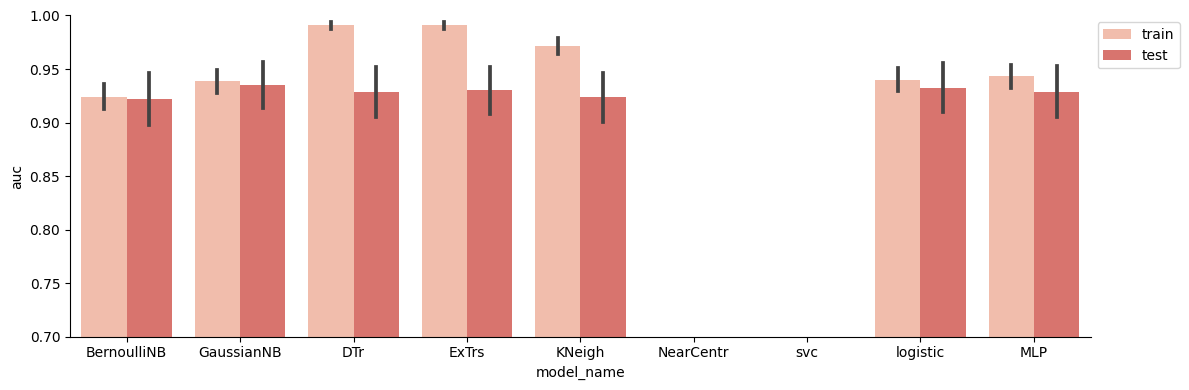

In [9]:
for metric in result_df.columns[3:]:

    fig, ax = plt.subplots(figsize=(12,4))

    sns.barplot(
        data = result_df.filter(['fold_id', 'model_name', 'set'] + [metric]),
        x="model_name", y=metric, hue="set",
        palette="Reds", alpha=.75, ax=ax, errorbar='sd'
    )

    sns.despine(top=True, right=True)

    # Set y-axis limits
    ax.set_ylim(0.7, 1)

    # Move legend outside of the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()  # Adjust layout so everything fits nicely
    plt.show()

In [10]:
# Saving Result
result_df.to_csv('Data/ResultsExperiment1.csv')

# Experiment 2

Based on experiment 1 results for recall, which measures the rate of values correctly predicted positive and the real positive, we designate for further exploration and hyperparameter fine-tunning the models:

* _GaussianNB_: with the smallest overfitting in average between training and test sets as well as one of the best performing.
* _MLP_.
* _SVC_. 

For the last two, there's a slighly higher overfitting. The testing set evaluation is less disperse when compared with the Gaussian, with SVC being the most promising on this regard.